In [9]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import linecache

In [70]:
# set data path
basepath = "/home/emily/Desktop/isamoa_data/"
mpipath = basepath + "good5_sb32n16t_d26min66_mpi_1458983"
fitpath = basepath + "good3_sb32n16t_d26min66_irmfit_1458883"

jobid = mpipath[-7:]
mpi_filename = mpipath + '/' + jobid + '.log'
print(mpi_filename)

jobid = fitpath[-7:]
fit_filename = fitpath + '/' + jobid + '.log'
print(fit_filename)

files = [mpi_filename, fit_filename]
labels = ['Static MPI 512 ranks: # ranks','Elastic MPI: # ranks']
labels2 = ['Static MPI 512 ranks: # cells','Elastic MPI: # cells']
colors = ['red','blue']
colors2 = ['magenta','seagreen']

/home/emily/Desktop/isamoa_data/good5_sb32n16t_d26min66_mpi_1458983/1458983.log
/home/emily/Desktop/isamoa_data/good3_sb32n16t_d26min66_irmfit_1458883/1458883.log


# Process Data from 2 files

In [104]:
all_nranks = []
all_ncells = []
all_nelaps = []
all_mcells = []
all_msteps = []

all_tsu_ranks = []
all_tsu_ts_et = []
all_tsu_lb_et = []
all_tsu_adp_et = []

for file in files:

    nranks = []
    ncells = []
    nelaps = []
    mcells = []
    msteps = []

    markers = []
    tsu_ranks = []
    tsu_ts_et = []
    tsu_lb_et = []
    tsu_adp_et = []
    
    #################
    # MPI Ranks
    #################
    f = open(file, 'r')
    for i, line in enumerate(f,1):

        # find all "phase statistics" line numbers
        if "Phase statistics:" in line:
            markers = markers + [i]

        # Get nranks & ncells vs. time
        if ">>>" in line:
            larr = line.split()
            try:
                ranks = int(larr[-1])
                cells = int(larr[-3][:-1])
                elaps = float(larr[-5][:-1])
            except:
                pass
            else: 
                nranks = nranks + [ranks]
                nelaps = nelaps + [elaps]
                ncells = ncells + [cells * ranks]   

            # Get mcells vs. time steps
            if "time step:" in line:
                idx = larr.index('step:')
                msteps = msteps + [int(larr[idx+1][:-1])]
                idx = larr.index('cells:')
                mcells = mcells + [cells * ranks]      
    f.close()
    all_nranks = all_nranks + [nranks]
    all_ncells = all_ncells + [ncells]
    all_nelaps = all_nelaps + [nelaps]
    all_mcells = all_mcells + [mcells]
    all_msteps = all_msteps + [msteps]

    #################
    # Throughput
    #################
    
    # Remove the Init and EQ phase
    markers = markers[2:]  
    
    for marker in markers:
        
        # ranks
        line = linecache.getline(file, marker+2)
        larr = line.split()
        tsu_ranks = tsu_ranks + [int(larr[-1])]
        
        # Tsunami Time step throughput
        line = linecache.getline(file, marker+5)
        larr = line.split()
        idx = larr.index("ET:")
        tsu_ts_et = tsu_ts_et + [1/float(larr[idx+1])]
        
        # Tsuanmi Load Balancing throughput
        line = linecache.getline(file, marker+6)
        larr = line.split()
        idx = larr.index("time:")
        adap_time = float(larr[idx+1])
        idx = larr.index("ET:")
        adap_et = float(larr[idx+1])
        idx = larr.index("balancing:")
        lb_time = float(larr[idx+1])
        tsu_lb_et = tsu_lb_et + [lb_time / (adap_time*adap_et)]
        
        # Tsuanmi Load Balancing throughput
        idx = larr.index("neighbors:")
        updnb_time = float(larr[idx+1])
        tsu_adp_et = tsu_adp_et + [(adap_time - updnb_time) / (adap_time*adap_et)]
        
    all_tsu_ranks = all_tsu_ranks + [tsu_ranks]
    all_tsu_ts_et = all_tsu_ts_et + [tsu_ts_et]
    all_tsu_lb_et = all_tsu_lb_et + [tsu_lb_et]
    all_tsu_adp_et = all_tsu_adp_et + [tsu_adp_et]


# # Cells vs. Time step

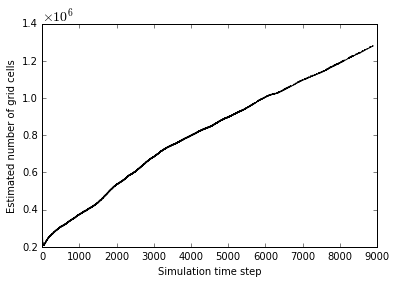

In [142]:
fig = plt.figure()
ax = fig.gca()

mcells = np.divide(np.array(all_mcells[0]), 1000000).tolist()
msteps = all_msteps[0]

ax.plot(msteps, mcells, color='black')
ax.set_xlabel("Simulation time step")
ax.set_ylabel("Estimated number of grid cells")
ax.text(-10, 1.41, r'$\times 10^{6}$', fontsize=14)
    
fig.savefig(basepath+"/cells_vs_steps.pdf",bbox_inches="tight")

# CPU-Hour Comparison

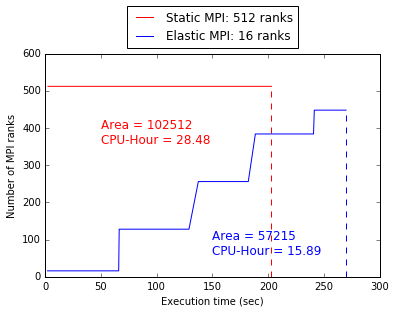

In [143]:
fig = plt.figure()
ax = fig.gca()
#ax2 = ax.twinx()

areas = [None] * len(files)
cpuhr = [None] * len(files)

for i in range(0, len(files)):
    nelaps = all_nelaps[i]
    nranks = all_nranks[i]
    ncells = all_ncells[i]
    # Plot Ranks
    ax.plot(nelaps, nranks, color=colors[i], label=labels[i])
    ax.plot((nelaps[-1], nelaps[-1]), (0, nranks[-1]), color=colors[i], linestyle='--')
    areas[i] = np.trapz(nranks, x=nelaps)
    cpuhr[i] = areas[i]/3600
    # Plot Cells
#    ax2.plot(nelaps, ncells, color=colors2[i], label=labels2[i])

# Ranks
ax.set_xlabel("Execution time (sec)")
ax.set_ylabel("Number of MPI ranks")
lgd = ax.legend(loc="lower center", bbox_to_anchor=(0.5, 1))
lgd = ax2.legend(loc="lower center", bbox_to_anchor=(0.5, 1))

ax.text(50, 400, r'Area = %d' % areas[0], color=colors[0], fontsize=12)
ax.text(50, 360, r'CPU-Hour = %.2f' % cpuhr[0], color=colors[0], fontsize=12)
ax.text(150, 100, r'Area = %d' % areas[1], color=colors[1], fontsize=12)
ax.text(150, 60, r'CPU-Hour = %.2f' % cpuhr[1], color=colors[1], fontsize=12)

# Cells
#ax2.set_ylim(0, 1600000)

fig.savefig(basepath + "/cpu-hr_comparison.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Throughput Comparison

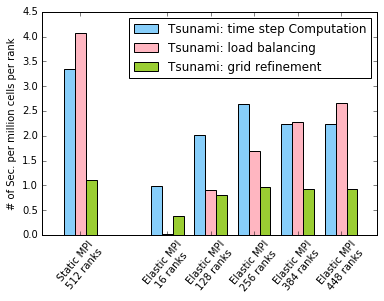

In [145]:
fig = plt.figure()
ax = fig.gca()

# The first data is from MPI
tsu_ranks = all_tsu_ranks[0]
tsu_ts_et = all_tsu_ts_et[0]
tsu_lb_et = all_tsu_lb_et[0]
tsu_adp_et = all_tsu_adp_et[0]
        
# The rest are from iMPI Fit
tsu_ranks = tsu_ranks + all_tsu_ranks[1]
tsu_ts_et = tsu_ts_et + all_tsu_ts_et[1]
tsu_lb_et = tsu_lb_et + all_tsu_lb_et[1]
tsu_adp_et = tsu_adp_et + all_tsu_adp_et[1]

# xtick labels
x_labels = []
str = 'Static MPI\n%d ranks' % tsu_ranks[0]
x_labels = x_labels + [str]
for i in range(1,len(tsu_ranks)):
    str = 'Elastic MPI\n%d ranks' % tsu_ranks[i]
    x_labels = x_labels + [str]

# xtick locations
loc = np.arange(len(tsu_ts_et))
for i in loc[1:]:
    loc[i] = loc[i] + 1

# bar width
width = 0.25

# plot 3 data series
ax.bar(loc, tsu_ts_et, width, color='lightskyblue', label='Tsunami: time step Computation')
ax.bar(loc+width, tsu_lb_et, width, color='lightpink', label='Tsunami: load balancing')
ax.bar(loc+width*2, tsu_adp_et, width, color='yellowgreen', label='Tsunami: grid refinement')

# setting
ax.legend()
ax.set_xticks(loc + width*1.5, )
ax.set_xticklabels(x_labels, rotation=50)
ax.set_xlim(-0.5,7.2)
ax.set_ylabel('# of Sec. per million cells per rank')

# Save figure
fig.savefig(basepath + "/thruput_comparison.pdf", bbox_inches='tight')